<a href="https://colab.research.google.com/github/FabioPojo1987/FabioPojo1987-MVP_2_DATA_SCIENCE_PUC_RIO/blob/main/MVP_2_DATA_SCIENCE_PUC_Rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto de MVP da 2ª Sprint do curso de Ciência de Dados na PUC-Rio (por Fabio Pojo de Almeida).**


Este projeto se trata na construção de um modelo de aprendizado de máquina ("machine learning") para criar insights sobre como ocorre a variação de dados dos valores das ações do Google no Mercado de Ações.

Onde foi utilizado um recorte temporal compreendido entre os anos de 2010 e 2023

Este projeto está baseado em um modelo de "Rede Neural Recorrente" e está usando de referência os dados presentes nas planilhas csv

Para isso, foi decidido um exemplo onde esses dados foram separados em duas bases em 2 arquivos diferentes: 1- base de treino e 2- teste (a faixa da base de teste tem como referência um período de 3 semanas, ou 21 dias)

- A base de dados utilizada para os valores das ações do Google (Alphabet.inc.) foi obtida através do Kaggle em: https://www.kaggle.com/datasets/alirezajavid1999/google-stock-2010-2023/download?datasetVersionNumber=1


Campos do dataset :

1.   Date
2.   Open - Valor das ações na Abertura
3.   High - Valor mais alto do dia ("Pico")
4.   Low - Valor mais baixo ("vale")
5.   Volume - Volume a ser Negociado
6.   High - Close : Valor (a maior) no momento de fechamento


Objetivo - Usar os dados de treino para prever os valores que estão nos dados de teste, o objetivo é comparar a previsão do modelo com o que de fato aconteceu.





In [6]:
# Importar as bibliotecas
import numpy as np # vai ser usado pra criar os arrays
import matplotlib.pyplot as plt # para gerar graficos
import pandas as pd

In [7]:
url_dados = 'https://raw.githubusercontent.com/FabioPojo1987/FabioPojo1987-MVP_2_DATA_SCIENCE_PUC_RIO/main/Google_Stock_Train%20(2010-2022).csv'

In [8]:
#importar os dados
dataset_train = pd.read_csv(url_dados)
training_set = dataset_train.iloc[:, 1:2].values # separar apenas os atributos
# que usaremos no modelo

In [9]:
#Transformação
from sklearn.preprocessing import MinMaxScaler # criar valores numa mesma escala
sc = MinMaxScaler(feature_range = (0, 1)) # a normalização será entre 0 e 1
training_set_scaled = sc.fit_transform(training_set) # aplicar os dados na normalização

In [10]:
#Estruturas de dados com 60 intervalos de tempo, vamos pegar
# sempre 60 dias pra prever a proxima saida
X_train = [] # cria lista do python pra pegar os 60 dias
y_train = [] # essa lista preve o proximo dia
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
# Colocar os dados no formatos que o Keras exige, ele precisa estar em três dimensões
# batch_size, timesteps( intervalos de treinamento, e numero de indicadores que serão usados)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
#Importando bibliotecas do Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [13]:
#Inicializar a rede neural
regressor = Sequential()
#Criando as camadas
#1
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
#2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#3
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#4
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# camada de saída
regressor.add(Dense(units = 1))

In [14]:
#Compilando a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
#Treinando
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 11s 95ms/step - loss: 4.5558e-04
Epoch 2/100
38/38 [==============================] - 5s 122ms/step - loss: 1.0557e-04
Epoch 3/100
38/38 [==============================] - 4s 103ms/step - loss: 1.0408e-04
Epoch 4/100
38/38 [==============================] - 4s 94ms/step - loss: 9.7808e-05
Epoch 5/100
38/38 [==============================] - 4s 98ms/step - loss: 8.2855e-05
Epoch 6/100
38/38 [==============================] - 4s 116ms/step - loss: 7.9163e-05
Epoch 7/100
38/38 [==============================] - 4s 95ms/step - loss: 7.8238e-05
Epoch 8/100
38/38 [==============================] - 4s 94ms/step - loss: 7.0412e-05
Epoch 9/100
38/38 [==============================] - 5s 120ms/step - loss: 8.5553e-05
Epoch 10/100
38/38 [==============================] - 4s 95ms/step - loss: 9.5417e-05
Epoch 11/100
38/38 [==============================] - 4s 96ms/step - loss: 6.1070e-05
Epoch 12/100
38/38 [==============================] - 5s 1

In [15]:
url_dados2 = 'https://github.com/FabioPojo1987/FabioPojo1987-MVP_2_DATA_SCIENCE_PUC_RIO/blob/main/Google_Stock_Price_(2010-2023).csv'

In [16]:
#Obtendo os dados reais
import pandas as pd
dataset_test = pd.read_csv('Google_Stock_Test_(2010-2023).csv')
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price = dataset_test.iloc[:, 1:2].values # pegar apenas coluna de saída, a Open

In [17]:
#Obtendo os dados previstos
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1) # transformar a variável passando -1 e 1 como parâmetro
inputs = sc.transform(inputs) # fazer a normalização
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 1s/step


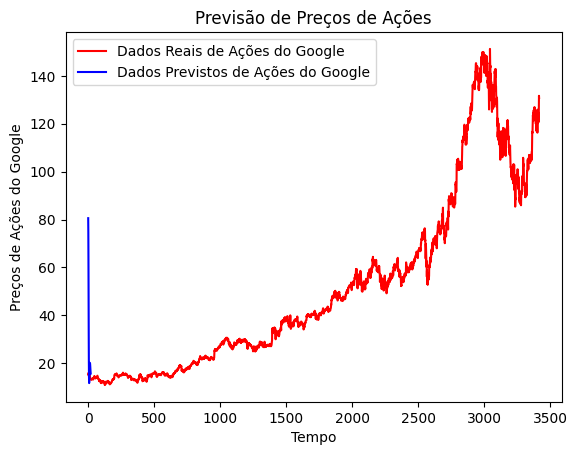

In [18]:
#Visualizando os Resultados
plt.plot(real_stock_price, color = 'red', label = 'Dados Reais de Ações do Google')
plt.plot(predicted_stock_price, color = 'blue', label = 'Dados Previstos de Ações do Google')
plt.title('Previsão de Preços de Ações')
plt.xlabel('Tempo')
plt.ylabel('Preços de Ações do Google')
plt.legend()
plt.show()

A partir deste trabalho, foi possível observar que o sistema de previsão até que conseguiu obter uma tendência bem interessante, especialmente sendo bem útil para pessoas que lidam com o mercado de ações na Bolsa de Valores.

Contudo, ainda assim o algoritmo não conseguiu acertar as tendências. Errou em parte.

Pois, utilizar esse tipo de metodologia (para tentar prever dados de ações financeiras) é algo bastante complexo e demanda muito tempo e poder de processamento para ter mais eficiência e precisão.

Fora que, devido ao fato de se lidar com informações de risco, não é aconselhavel de se basear os investimentos de capital em modelos de simulação como esse.

Porém, pode-se utilizar esse tipo de metodologia pra estudar e aprender novas possibilidades de previsões e de tendência.